# Feature Visualization based on VGG19 convolutionnal network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.applications import VGG19
from PIL import Image
from tqdm import tqdm

STYLE_PATH = "../data/style"
CONTENT_PATH = "../data/content"

IMAGE_SHAPE = (512, 512, 3)

## Import and resize input images

In [2]:
raw_style = Image.open(f"{STYLE_PATH}/vangogh.png")
raw_content = Image.open(f"{CONTENT_PATH}/ensc.png")

In [3]:
content_img = raw_content.resize(IMAGE_SHAPE[0:2], Image.ANTIALIAS)
style_img = raw_style.resize(IMAGE_SHAPE[0:2], Image.ANTIALIAS)

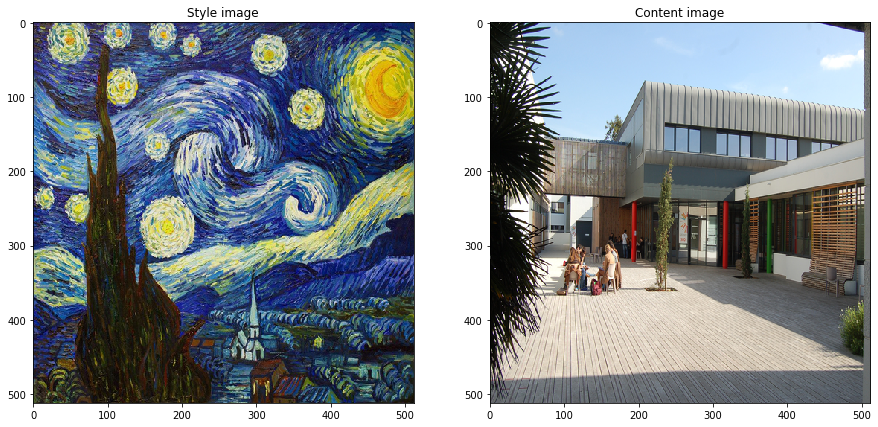

In [4]:
fig = plt.figure(figsize=(15, 10))

axes = fig.add_subplot(1, 2, 1)
axes.imshow(style_img)
axes.set_title("Style image")

axes = fig.add_subplot(1, 2, 2)
axes.imshow(content_img)
axes.set_title("Content image")

plt.show(fig)

## Preprocess images

Images are preprocessed to respect the training input policy of VGG19.

In [5]:
content_img = np.array(content_img)
style_img = np.array(style_img)

In [6]:
content_img = np.expand_dims(content_img, axis=0)
style_img = np.expand_dims(style_img, axis=0)

In [7]:
print(f"Content shape : {content_img.shape}")
print(f"Style shape : {style_img.shape}")

Content shape : (1, 512, 512, 3)
Style shape : (1, 512, 512, 3)


In [8]:
content_img = keras.applications.vgg19.preprocess_input(content_img)
style_img = keras.applications.vgg19.preprocess_input(style_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


151.061

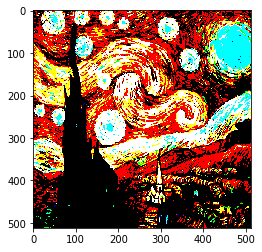

In [46]:
plt.imshow(np.squeeze(style_img))

style_img.max()

## Load model

In [9]:
vgg = VGG19(include_top=False,  weights='imagenet', input_shape=IMAGE_SHAPE)
vgg.trainable = False

In [10]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0     

In [11]:
def get_vgg_layer(vgg, layer_name: str, model_name: str=None) -> keras.models.Model:
    output = vgg.get_layer(layer_name).output
    return keras.models.Model(vgg.input, output, name=model_name)

In [19]:
block1 = get_vgg_layer(vgg, "block1_conv1", "block1")
block2 = get_vgg_layer(vgg, "block2_conv1", "block2")
block3 = get_vgg_layer(vgg, "block3_conv4", "block3")

In [20]:
block1.summary()

Model: "block1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
Total params: 38,720
Trainable params: 0
Non-trainable params: 38,720
_________________________________________________________________


## Create loss and gradient function

We want the latent space representation of the input noise to fit the latent space representation of the input image.

In [21]:
def get_features_loss(noise_features, features_target):
    return tf.reduce_mean(tf.square(noise_features - features_target))

In [22]:
def compute_loss(model, init_noise, features):
    model_outputs = model(init_noise)
    return get_features_loss(model_outputs, features)

In [23]:
def compute_grads(model, init_noise, features):
    with tf.GradientTape() as tape: 
        tape.watch(init_noise)
        loss = compute_loss(model, init_noise, features)
    return tape.gradient(loss, init_noise), loss

## Train on noise image

For VGG block 1.

In [31]:
iterations = 100
opt = tf.keras.optimizers.SGD(5)

init_noise = tf.Variable(tf.random.normal([1, *IMAGE_SHAPE])) #WARNING: toujours mettre les trucs utilisés par le
                                                              #GradientTape en tf.Variable ("mutable tensor") sinon c'est 
                                                              #la hez
features = block1(style_img)

100%|██████████| 100/100 [01:25<00:00,  1.17it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


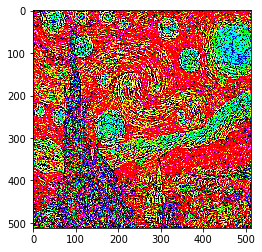

In [32]:
norm_means = np.array([103.939, 116.779, 123.68])
min_vals = -norm_means
max_vals = 255 - norm_means 

history = []
best_loss = float("inf")
best_img = np.squeeze(init_noise.numpy().copy())

for i in tqdm(range(iterations)):
    grads, loss = compute_grads(block1, init_noise, features)
    opt.apply_gradients([(grads, init_noise)])
    clipped = tf.clip_by_value(init_noise, min_vals, max_vals)
    init_noise.assign(clipped) 
    
    history.append(loss)
    
    if loss < best_loss:
        best_loss = loss
        best_img = np.squeeze(init_noise.numpy().copy())
        
    if i % 10 == 0:
        Image.from_array()
        
plt.imshow(best_img)

In [49]:
def deprocess_image(x):
    if tf.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [50]:
img = deprocess_img(best_img)

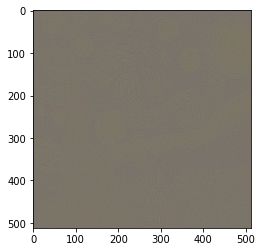

In [51]:
plt.imshow(img)